# Basic demo of training GNN on boid model.
All the scripts are in **scripts.gnn.gnn** and **scripts.gnn.gnn_definition**.
The scripts build barebone GNN network architecture, handling of discrete data. 
The notebook illustrates training and testing and demos of single-frame prediction.

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [29]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [30]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets

### 1. Load data

In [8]:
dataset = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_short.pt",
    weights_only=False,
)
species_configs = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_short_config.pt",
    weights_only=False,
)

In [6]:
dataset = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_subsample.pt",
    weights_only=False,
)
species_configs = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_subsample_config.pt",
    weights_only=False,
)

In [31]:
dataset = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic.pt",
    weights_only=False,
)
species_configs = torch.load(
    "/workspace/collab-environment/collab_env/data/boids/boid_single_species_basic_config.pt",
    weights_only=False,
)

In [32]:
# split data into training set and test set
test_size = int(len(dataset) / 2)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2025)
)

In [33]:
# create mini-batches
batch_size = 1
# right now we assume the batch_size = 1, because our real dataset are of different lengths.
# But we can expand to minibatches - except fpr a few specific functions, every function is written with minibatches in mind.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

batch = list(iter(train_loader))[0]
pos, species = batch

print("made", str(len(list(train_loader))), "batches, each of size", str(batch_size))  #
print(
    "Batch position:", pos.shape
)  # [Batch size, Number of boids, coordinates (x,y pos)= 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 25 batches, each of size 1
Batch position: torch.Size([1, 1000, 20, 2])
Species labels: torch.Size([1, 20])




### 2. Train GNN and our lazyGNN
The lazy model only outputs a zero acceleration at all frames.

In [34]:
# Specify various model configurations
models = {}

models["vpluspplus_a"] = {}
models["vpluspplus_a"][
    "node_feature_function"
] = "vel_plus_pos_plus"  # features are velocity(t-2), velocity(t-1), velocity(t)
models["vpluspplus_a"]["node_prediction"] = "acc"  # predict model acceleration
models["vpluspplus_a"]["prediction_integration"] = "Euler"  # predict model acceleration
models["vpluspplus_a"]["input_differentiation"] = "finite"
models["vpluspplus_a"]["in_node_dim"] = 6 + 6 + 6 + 1
models["vpluspplus_a"]["start_frame"] = 3
models["vpluspplus_a"]["lr"] = 1e-3

models["lazy"] = {}
models["lazy"]["node_feature_function"] = None
models["lazy"]["node_prediction"] = None
models["lazy"]["prediction_integration"] = "Euler"  # predict model acceleration
models["lazy"]["input_differentiation"] = "finite"
models["lazy"]["in_node_dim"] = 3
models["lazy"]["start_frame"] = None
models["lazy"]["lr"] = None

In [40]:
sigma = 0.005
for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
        lr,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
        models[m]["lr"],
    )

    # initialize models
    if m == "lazy":
        training = True
        lr = None
        gnn_model = Lazy(
            model_name=m,
            input_differentiation=input_differentiation,
            prediction_integration=prediction_integration,
            heads=1,
            in_node_dim=in_node_dim,
        )
        epoch_num = 1  # number of training epochs

    else:
        training = True
        gnn_model = GNN(
            model_name=m,
            node_feature_function=node_feature_function,
            node_prediction=node_prediction,
            input_differentiation=input_differentiation,
            prediction_integration=prediction_integration,
            start_frame=start_frame,
            heads=1,
            in_node_dim=in_node_dim,
        )

        epoch_num = 5  # number of training epochs

    visual_range = (
        0.5  # visual range, give a large number, ask the network to prune for us!
    )

    # train models
    (models[m]["train_losses"], models[m]["model"], models[m]["debug_result"]) = (
        train_rules_gnn(
            gnn_model,
            train_loader,
            visual_range=visual_range,
            epochs=epoch_num,
            sigma = sigma,
            lr=lr,
            training=training,
            species_dim=len(torch.unique(species)),
            device = None,
            full_frames = False,
        ) 
    )

    models[m]["W_input"], models[m]["W_output"] = get_adjcency_from_debug(
        models[m]["debug_result"], train_loader, visual_range
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0027
epoch 1


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


epoch 2


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


epoch 3


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 

In [38]:
# save model
for m in ["vpluspplus_a", "lazy"]:
    gnn_model = models[m]["model"]
    model_output = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{gnn_model.name}_basic_noise_{sigma}_specialframes.pt"
    torch.save(gnn_model.state_dict(), model_output)

In [39]:
model_output

'/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_lazy_basic_noise_0.001_specialframes.pt'

### 3. Investigate loss 

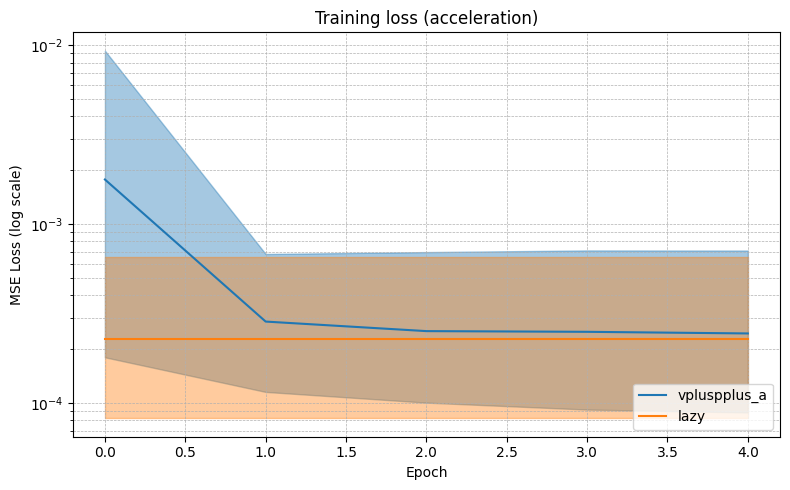

In [10]:
loss_all = [models[m]["train_losses"] for m in ["vpluspplus_a"]]

loss_all.append(np.tile(models["lazy"]["train_losses"], (loss_all[0].shape[0], 1)))

plot_log_loss(
    loss_all, [m for m in models], alpha=0.05, title="Training loss (acceleration)"
)
plt.show()

# loss_all = [models[m]["train_losses"] for m in models]
# plot_log_loss(loss_all,[m for m in models],
#              alpha = 0.05,
#              title = "Training loss")

### MSE on position prediction

In [236]:
# TO DO: move this into a function
loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["debug_result"].keys())[-1]

    for file_id in models[m]["debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    loss_mse_all[m] = loss_m

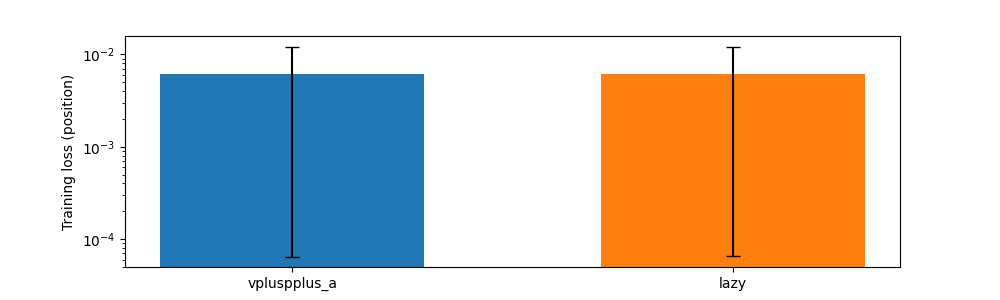

In [237]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(loss_mse_all[m])
    std_devs = 2 * np.std(loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color="black", capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Training loss (position)")
plt.yscale("log", base=10)
plt.show()

### To investigate one model on one file

#### a) video, overlay trajectories on top of each other.

In [11]:
file_id = 2
m = "lazy"
epoch_num = 0
actual = np.concatenate(models[m]["debug_result"][epoch_num][file_id]["actual"], axis=0)
predicted_lazy = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
)

actual_acc = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["actual_acc"], axis=0
)
predicted_acc_lazy = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted_acc"], axis=0
)

loss_acc_lazy = np.array(models[m]["debug_result"][epoch_num][file_id]["loss"])

m = "vpluspplus_a"
epoch_num = 2

predicted_gnn = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted"], axis=0
)

predicted_acc_gnn = np.concatenate(
    models[m]["debug_result"][epoch_num][file_id]["predicted_acc"], axis=0
)

loss_acc_gnn= np.array(models[m]["debug_result"][epoch_num][file_id]["loss"])

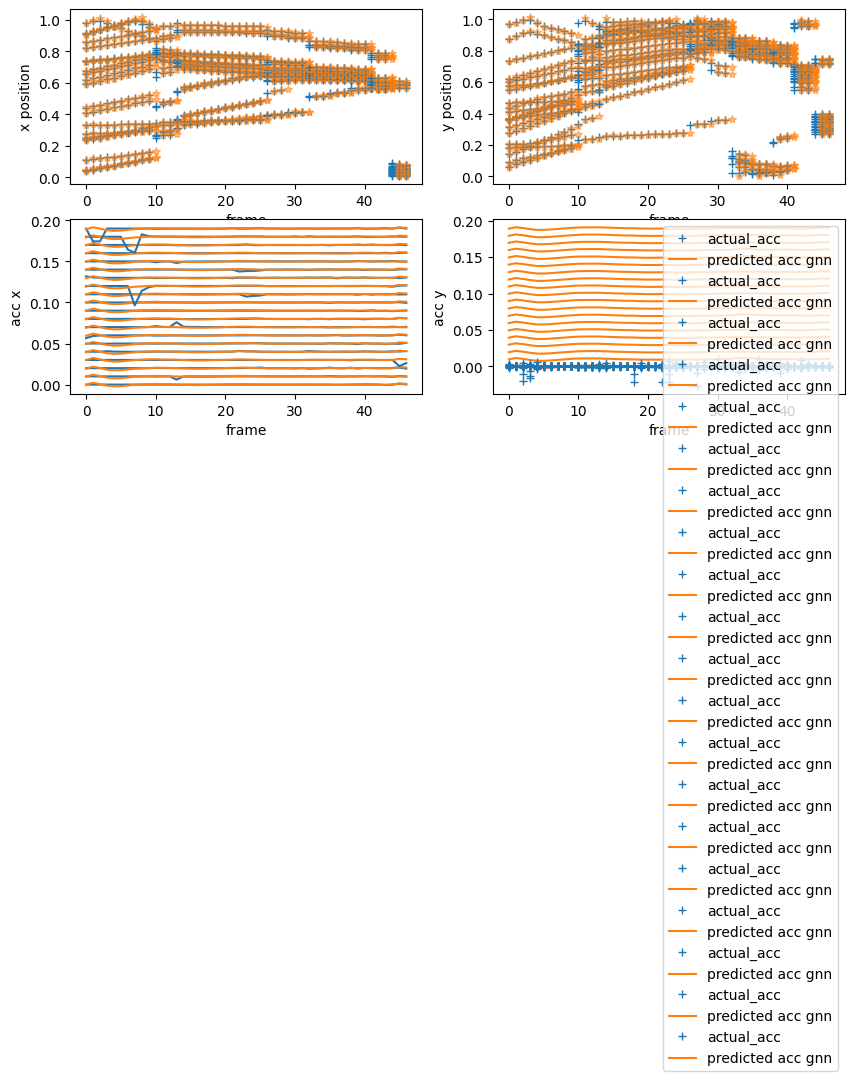

In [18]:
%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.ravel()

for b in np.arange(20):

    ax[0].plot(actual[:, b, 0], "+", color = 'C0', label="actual")
    #ax[0].plot(predicted_lazy[:, b, 0], "*", label="predicted lazy", alpha=0.5)
    ax[0].plot(predicted_gnn[:, b, 0], "*", color = 'C1',label="predicted gnn", alpha=0.5)
    
    #ax[0].set_title("bird " + str(b))
    
    ax[1].plot(actual[:, b, 1], "+", color = 'C0', label="actual")
    #ax[1].plot(predicted_lazy[:, b, 1], "*", label="predicted lazy", alpha=0.5)
    ax[1].plot(predicted_gnn[:, b, 1], "*", color = 'C1',label="predicted gnn", alpha=0.5)
    
    #ax[1].set_title("bird " + str(b))
    
    ax[2].plot(actual_acc[:, b, 0] + 0.01 * b, color = 'C0', label="actual_acc")
    #ax[2].plot(predicted_acc_lazy[:, b, 0], "+", label="predicted acc lazy")
    ax[2].plot(predicted_acc_gnn[:, b, 0] + 0.01 * b, color = 'C1',label="predicted acc gnn")
    #ax[2].plot(loss_acc, label="acc loss")
    
    
    ax[3].plot(actual_acc[:, b, 1], "+", color = 'C0', label="actual_acc")
    #ax[3].plot(predicted_acc_lazy[:, b, 1], "+", label="predicted acc lazy")
    ax[3].plot(predicted_acc_gnn[:, b, 1] + 0.01 * b, color = 'C1',label="predicted acc gnn")

ax[0].set_xlabel("frame")
ax[0].set_ylabel("x position")

ax[1].set_xlabel("frame")
ax[1].set_ylabel("y position")

ax[2].set_xlabel("frame")
ax[2].set_ylabel("acc x")

#ax[3].plot(loss_acc, label="acc loss")
ax[3].set_xlabel("frame")
ax[3].set_ylabel("acc y")

plt.legend()
plt.show()


#### b) visualize the dynamic weight matrices
Because the attention layer is a function 
$$A: F \times F \rightarrow \mathbb{R} $$, where $F$ is the space of node feature, a subset of $\mathbb{R}^n$, n is the dimensionality of the input layer size, we obtain dynamic adjacency matrix as boids move around producing dynamic node features.

In [141]:
m = "vpluspplus_a"
W_output = models[m]["W_output"]

In [142]:
# choose a file
file_id = 3

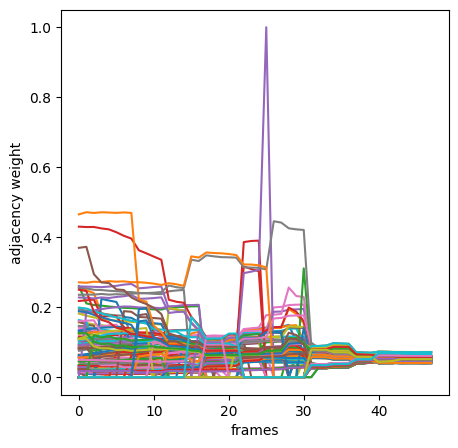

In [143]:
%matplotlib inline


final_epoch = list(W_output.keys())[-1]
W_output_overtime = W_output[final_epoch][file_id]
frames = np.arange(0, len(W_output_overtime))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pairs = combinations(np.arange(np.shape(W_output_overtime[0])[0]), 2)
for p in pairs:
    W_output_overtime_ij = [W_output_overtime[t][p[0], p[1]] for t in frames]
    plt.plot(frames, W_output_overtime_ij)
plt.xlabel("frames")
plt.ylabel("adjacency weight")
plt.show()

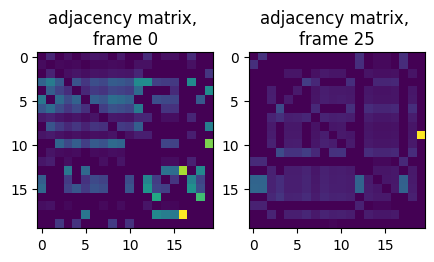

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
f0 = 0
f1 = 25
ax[0].imshow(W_output_overtime[f0])
ax[0].set_title(f"adjacency matrix, \nframe {f0}")
ax[1].imshow(W_output_overtime[f1])
ax[1].set_title(f"adjacency matrix, \nframe {f1}")
plt.show()

## 4. Validate on held-out dataset

In [26]:
old_name = "vpluspplus_a"
new_name = old_name
model_path = f"/workspace/collab-environment/collab_env/gnn/trained_models/boid_single_species_{old_name}_basic_special_frames.pt"

models = load_model(new_name, model_path)


NameError: name 'GNN' is not defined

In [146]:
torch.cuda.empty_cache()

In [147]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloader_list = list(test_loader)
visual_range = 0.5

/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [30]:
training = False
epoch_num = 1
lr = None

for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["test_losses"], _, models[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
    )

    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0




<string>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(Tr

batch 1


batch 2


batch 3


batch 4


batch 5




KeyboardInterrupt: 

### Acceleration loss

In [ ]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(models[m]["test_losses"])
    std_devs = 2 * np.std(models[m]["test_losses"])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (acceleration)")
plt.yscale("log", base=10)
plt.show()

### MSE position loss

In [ ]:
test_loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["test_debug_result"].keys())[-1]

    for file_id in models[m]["test_debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    test_loss_mse_all[m] = loss_m

In [ ]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(test_loss_mse_all[m])
    std_devs = 2 * np.std(test_loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (position)")
plt.yscale("log", base=10)
plt.show()

## 5. Visualize heldout data.

In [241]:
training = False
epoch_num = 1
lr = None
full_frames = True

for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["test_losses"], _, models[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        full_frames = full_frames,
        species_dim=len(torch.unique(species)),
        device=None,
    )

    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0




<string>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(Tr

KeyboardInterrupt: 

In [ ]:
file_id = 2
m = "lazy"
epoch_num = 0
actual = np.concatenate(models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0)
predicted_lazy = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
)

m = "vpluspplus_a"

predicted_gnn = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
)

actual = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
)


loss_acc_gnn= np.array(models[m]["test_debug_result"][epoch_num][file_id]["loss"])

In [80]:
pos_gnn, vel_gnn, acc, v_function = handle_discrete_data(
    torch.tensor(predicted_gnn[np.newaxis, :]), "Euler")
pos, vel, acc, v_function = handle_discrete_data(
    torch.tensor(actual[np.newaxis, :]), "Euler")

p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


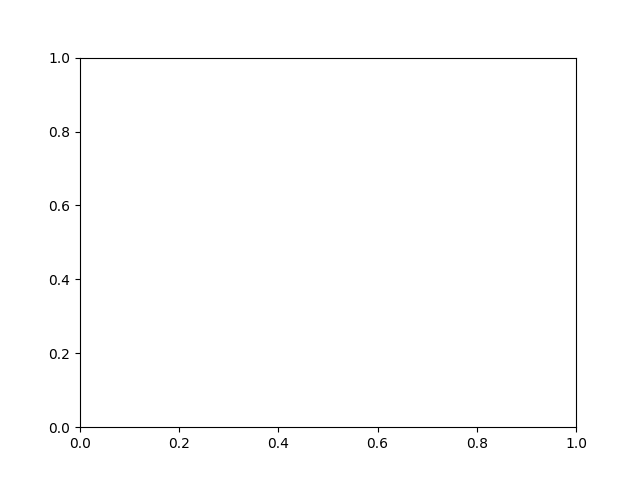

In [88]:
%matplotlib widget

ani, ax = visualize_graph_2sets(pos[0], vel[0], pos_gnn[0], vel_gnn[0],
                starting_frame = 0,
                file_id = 0)

### 6. Rollout

In [242]:
training = False
epoch_num = 1
lr = None
rollout = 5
prediction_integration = "Euler"

for m in ["vpluspplus_a"]:#models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        prediction_integration,
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["rollout_losses"], _, models[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
        rollout = rollout,
    )

    models[m]["rollout_W_input"], models[m]["rollout_W_output"] = get_adjcency_from_debug(
        models[m]["rollout_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 18.7207
finished one epoch


In [257]:
file_id = 8
epoch_num = 0

m = "vpluspplus_a"
rollout_debug_result = models[m]["rollout_debug_result"]
pos, vel, pos_gnn, vel_gnn, frame_sets = debug_result2prediction(rollout_debug_result,
                                                                 file_id = file_id, epoch_num = 0)

"""
m = "lazy"
"""

'\nm = "lazy"\n'

p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


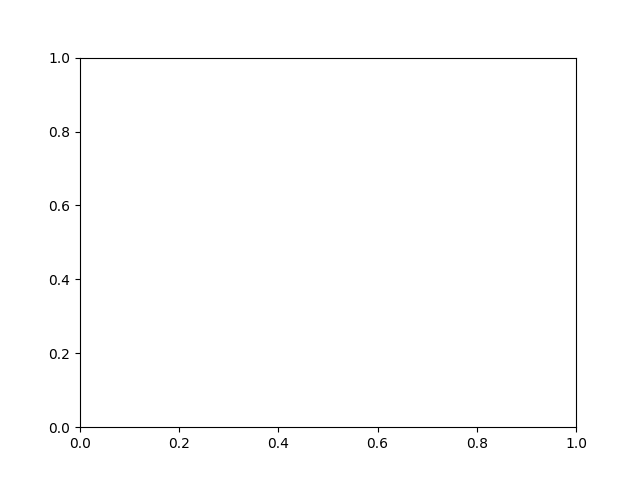

In [258]:
%matplotlib widget
starting_frame = 0
ending_frame = 300
ani, ax = visualize_graph_2sets(pos[0], vel[0], pos_gnn[0], vel_gnn[0],
                starting_frame = starting_frame, ending_frame = ending_frame,
                file_id = 0)

In [39]:
ani.save(f'boid_rollout_file{file_id}_frame{starting_frame}_frame{ending_frame}_{prediction_integration}.gif',
         writer='pillow', fps=20)

In [47]:
training = False
epoch_num = 1
lr = None
rollout = 10
prediction_integration = "leap"

for m in ["vpluspplus_a"]:#models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        prediction_integration,
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["rollout_losses_leap"], _, models[m]["rollout_debug_result_leap"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
        rollout = rollout,
    )

    models[m]["rollout_W_input_leap"], models[m]["rollout_W_output_leap"] = get_adjcency_from_debug(
        models[m]["rollout_debug_result_leap"], test_loader, visual_range
    )

epoch 0


batch 0


batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: inf
finished one epoch


In [48]:
file_id = 2
epoch_num = 0

m = "vpluspplus_a"
rollout_debug_result = models[m]["rollout_debug_result_leap"]
pos, vel, pos_gnn_leapfrog, vel_gnn_leapfrog, frame_sets = debug_result2prediction(
                                                                rollout_debug_result,
                                                                file_id = 2, epoch_num = 0)

rollout_debug_result = models[m]["rollout_debug_result"]
pos, vel, pos_gnn, vel_gnn, frame_sets = debug_result2prediction(rollout_debug_result,
                                                                 file_id = file_id, epoch_num = 0)


"""
m = "lazy"
"""

'\nm = "lazy"\n'

In [49]:
pos.shape

torch.Size([1, 996, 20, 2])

NameError: name 'pos_gnn_leapfrog' is not defined

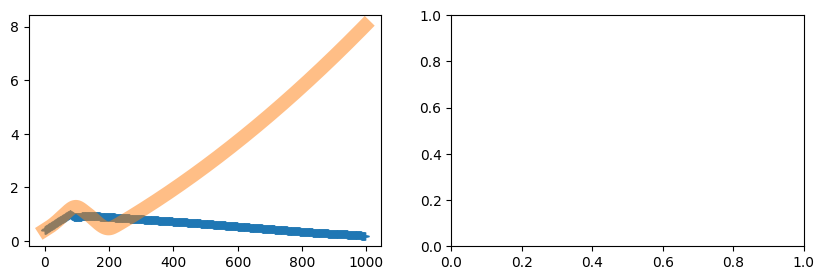

In [223]:
%matplotlib inline
b = 16
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

ax[0].plot(pos[0, :, b, 0], "+", label="actual")
ax[0].plot(pos_gnn[0, :, b, 0], linewidth = 10, label="predicted Euler", alpha=0.5)
ax[0].plot(pos_gnn_leapfrog[0, :, b, 0], "*", label="predicted leapfrog", alpha=0.5)
ax[0].set_xlabel("frame")
ax[0].set_ylabel("x position")
ax[0].set_title("bird " + str(b))

ax[1].plot(pos[0, :, b, 1], "+", label="actual")
ax[1].plot(pos_gnn[0, :, b, 1], linewidth = 10, label="predicted Euler", alpha=0.5)
ax[1].plot(pos_gnn_leapfrog[0, :, b, 1], "*", label="predicted leapfrog", alpha=0.5)
ax[1].set_xlabel("frame")
ax[1].set_ylabel("y position")
ax[1].set_title("bird " + str(b))

ax[0].set_xlim([0,rollout + 200])
ax[1].set_xlim([0,rollout + 200])
ax[0].set_ylim([-0.5,2])
ax[1].set_ylim([-0.5,2])
ax[0].axvline(rollout)
ax[1].axvline(rollout)

plt.legend()
plt.show()